In [2]:
!pip3 install timm==0.4.12 fairscale 
!git clone https://github.com/salesforce/BLIP
%cd BLIP

  Using cached timm-0.4.12-py3-none-any.whl.metadata (30 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 22.5 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332104 sha256=88dd40b859e0c3f9df359541d3c1c5fc59bfc5750428012c42f15c3bf534d79a
  Stored in directory: /root/.cache/pip/wheels/78/a4/c0/fb0a7ef03cff161611c3fa40c6cf898f76e58ec421b88e8cb3
Successfully built fairscale
  Attempting uninstall: timm
    Found existing installation: timm 1.0.7
    Uninstalling timm-1.0.7:
      Successfully uninstalled timm-1.0.7
Cloning into 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (30/30), done.
r

## BLIP: Inference Demo

In [3]:
## 加载示例图片
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

## 1.图片描述生成

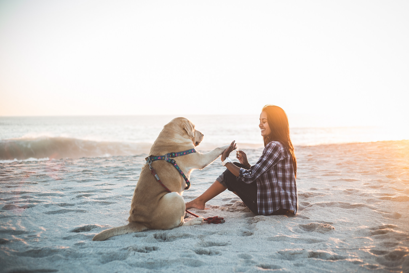

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a woman playing with her dog


In [6]:
from models.blip import blip_decoder

image_size = 384
image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])

## 视觉问答（VQA）

### 修改少量代码以解决版本问题

In [18]:
from models.med import BertConfig, BertModel, BertLMHeadModel
from models.blip import create_vit, init_tokenizer, load_checkpoint

import torch
from torch import nn
import torch.nn.functional as F
from transformers import BertTokenizer
import numpy as np

class BLIP_VQA(nn.Module):
    def __init__(self,                 
                 med_config = 'configs/med_config.json',  
                 image_size = 480,
                 vit = 'base',
                 vit_grad_ckpt = False,
                 vit_ckpt_layer = 0,                   
                 ):
        """
        Args:
            med_config (str): path for the mixture of encoder-decoder model's configuration file
            image_size (int): input image size
            vit (str): model size of vision transformer
        """               
        super().__init__()
        
        self.visual_encoder, vision_width = create_vit(vit, image_size, vit_grad_ckpt, vit_ckpt_layer, drop_path_rate=0.1)
        self.tokenizer = init_tokenizer()  
        
        encoder_config = BertConfig.from_json_file(med_config)
        encoder_config.encoder_width = vision_width
        self.text_encoder = BertModel(config=encoder_config, add_pooling_layer=False) 
        
        decoder_config = BertConfig.from_json_file(med_config)        
        self.text_decoder = BertLMHeadModel(config=decoder_config)          


    def forward(self, image, question, answer=None, n=None, weights=None, train=True, inference='rank', k_test=128):
        
        image_embeds = self.visual_encoder(image) 
        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)
        
        question = self.tokenizer(question, padding='longest', truncation=True, max_length=35, 
                                  return_tensors="pt").to(image.device) 
        question.input_ids[:,0] = self.tokenizer.enc_token_id
        
        if train:               
            '''
            n: number of answers for each question
            weights: weight for each answer
            '''                     
            answer = self.tokenizer(answer, padding='longest', return_tensors="pt").to(image.device) 
            answer.input_ids[:,0] = self.tokenizer.bos_token_id
            answer_targets = answer.input_ids.masked_fill(answer.input_ids == self.tokenizer.pad_token_id, -100)      

            question_output = self.text_encoder(question.input_ids, 
                                                attention_mask = question.attention_mask, 
                                                encoder_hidden_states = image_embeds,
                                                encoder_attention_mask = image_atts,                             
                                                return_dict = True)    

            question_states = []                
            question_atts = []  
            for b, n in enumerate(n):
                question_states += [question_output.last_hidden_state[b]]*n
                question_atts += [question.attention_mask[b]]*n                
            question_states = torch.stack(question_states,0)    
            question_atts = torch.stack(question_atts,0)     

            answer_output = self.text_decoder(answer.input_ids, 
                                              attention_mask = answer.attention_mask, 
                                              encoder_hidden_states = question_states,
                                              encoder_attention_mask = question_atts,                  
                                              labels = answer_targets,
                                              return_dict = True,   
                                              reduction = 'none',
                                             )      
            
            loss = weights * answer_output.loss
            loss = loss.sum()/image.size(0)

            return loss
            

        else: 
            question_output = self.text_encoder(question.input_ids, 
                                                attention_mask = question.attention_mask, 
                                                encoder_hidden_states = image_embeds,
                                                encoder_attention_mask = image_atts,                                    
                                                return_dict = True) 
            
            if inference=='generate':
                num_beams = 3
                question_states = question_output.last_hidden_state#.repeat_interleave(num_beams,dim=0)
                question_atts = torch.ones(question_states.size()[:-1],dtype=torch.long).to(question_states.device)
                model_kwargs = {"encoder_hidden_states": question_states, "encoder_attention_mask":question_atts}
                
                bos_ids = torch.full((image.size(0),1),fill_value=self.tokenizer.bos_token_id,device=image.device)
                
                outputs = self.text_decoder.generate(input_ids=bos_ids,
                                                     max_length=10,
                                                     min_length=1,
                                                     num_beams=num_beams,
                                                     eos_token_id=self.tokenizer.sep_token_id,
                                                     pad_token_id=self.tokenizer.pad_token_id, 
                                                     **model_kwargs)
                
                answers = []    
                for output in outputs:
                    answer = self.tokenizer.decode(output, skip_special_tokens=True)    
                    answers.append(answer)
                return answers
            
            elif inference=='rank':
                max_ids = self.rank_answer(question_output.last_hidden_state, question.attention_mask, 
                                           answer.input_ids, answer.attention_mask, k_test) 
                return max_ids
 
                
                
    def rank_answer(self, question_states, question_atts, answer_ids, answer_atts, k):
        
        num_ques = question_states.size(0)
        start_ids = answer_ids[0,0].repeat(num_ques,1) # bos token
        
        start_output = self.text_decoder(start_ids, 
                                         encoder_hidden_states = question_states,
                                         encoder_attention_mask = question_atts,                                      
                                         return_dict = True,
                                         reduction = 'none')              
        logits = start_output.logits[:,0,:] # first token's logit
        
        # topk_probs: top-k probability 
        # topk_ids: [num_question, k]        
        answer_first_token = answer_ids[:,1]
        prob_first_token = F.softmax(logits,dim=1).index_select(dim=1, index=answer_first_token) 
        topk_probs, topk_ids = prob_first_token.topk(k,dim=1) 
        
        # answer input: [num_question*k, answer_len]                 
        input_ids = []
        input_atts = []
        for b, topk_id in enumerate(topk_ids):
            input_ids.append(answer_ids.index_select(dim=0, index=topk_id))
            input_atts.append(answer_atts.index_select(dim=0, index=topk_id))
        input_ids = torch.cat(input_ids,dim=0)  
        input_atts = torch.cat(input_atts,dim=0)  

        targets_ids = input_ids.masked_fill(input_ids == self.tokenizer.pad_token_id, -100)

        # repeat encoder's output for top-k answers
        question_states = tile(question_states, 0, k)
        question_atts = tile(question_atts, 0, k)
        
        output = self.text_decoder(input_ids, 
                                   attention_mask = input_atts, 
                                   encoder_hidden_states = question_states,
                                   encoder_attention_mask = question_atts,     
                                   labels = targets_ids,
                                   return_dict = True, 
                                   reduction = 'none')   
        
        log_probs_sum = -output.loss
        log_probs_sum = log_probs_sum.view(num_ques,k)

        max_topk_ids = log_probs_sum.argmax(dim=1) 
        max_ids = topk_ids[max_topk_ids>=0,max_topk_ids]

        return max_ids
    
    
def blip_vqa(pretrained='',**kwargs):
    model = BLIP_VQA(**kwargs)
    if pretrained:
        model,msg = load_checkpoint(model,pretrained)
#         assert(len(msg.missing_keys)==0)
    return model  


def tile(x, dim, n_tile):
    init_dim = x.size(dim)
    repeat_idx = [1] * x.dim()
    repeat_idx[dim] = n_tile
    x = x.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    return torch.index_select(x, dim, order_index.to(x.device))    
        
        

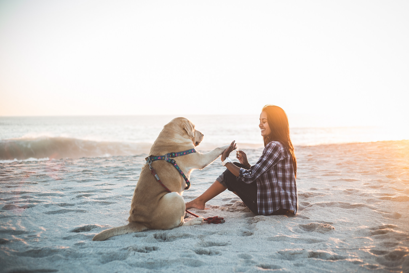

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth
answer: on beach


In [29]:
#from models.blip_vqa import blip_vqa

image_size = 480
image = load_demo_image(image_size=image_size, device=device)     

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
    
model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

question = 'where is the woman sitting?'

with torch.no_grad():
    answer = model(image, question, train=False, inference='generate') 
    print('answer: '+answer[0])

## 特征抽取

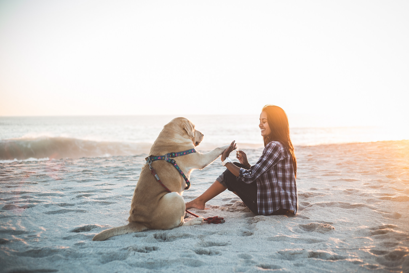

100%|██████████| 1.97G/1.97G [01:05<00:00, 32.3MB/s] 


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth


In [7]:
from models.blip import blip_feature_extractor

image_size = 224
image = load_demo_image(image_size=image_size, device=device)     

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'
    
model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

In [9]:
multimodal_feature.shape,image_feature.shape,text_feature.shape

(torch.Size([768]), torch.Size([768]), torch.Size([768]))

## 图文匹配

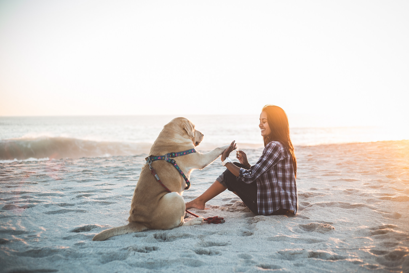

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: a woman sitting on the beach with a dog
The image and text is matched with a probability of 0.9960
The image feature and text feature has a cosine similarity of 0.5262


In [44]:
from models.blip_itm import blip_itm

image_size = 384
image = load_demo_image(image_size=image_size,device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
    
model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

print('text: %s' %caption)

itm_output = model(image,caption,match_head='itm')
itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print('The image and text is matched with a probability of %.4f'%itm_score)

itc_score = model(image,caption,match_head='itc')
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)

## huggingface 接口

In [7]:
## 图文匹配
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForImageTextRetrieval
import torch
model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")
processor = AutoProcessor.from_pretrained("Salesforce/blip-itm-base-coco")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')  
text = "a woman sitting on the beach with a dog"
inputs = processor(images=image, text=text, return_tensors="pt")

## 计算图文匹配度
itm_outputs= model(**inputs,use_itm_head=True)
itm_output=outputs.itm_score
itm_score=torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print('The image and text is matched with a probability of %.4f'%itm_score)

## 计算余弦相似度
itc_outputs= model(**inputs,use_itm_head=False)
itc_score=itc_outputs.itm_score
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)

The image and text is matched with a probability of 0.9960
The image feature and text feature has a cosine similarity of 0.5262


In [10]:
last_hidden_state=model.vision_proj(itc_outputs.last_hidden_state[:,0,:])
question_embeds=model.text_proj(itc_outputs.question_embeds[:,0,:])
last_hidden_state=last_hidden_state/last_hidden_state.norm(dim=-1,keepdim=True)
question_embeds=question_embeds/question_embeds.norm(dim=-1,keepdim=True)
question_embeds.shape,last_hidden_state.shape,question_embeds@last_hidden_state.T

(torch.Size([1, 256]),
 torch.Size([1, 256]),
 tensor([[0.5262]], grad_fn=<MmBackward0>))

In [14]:
## 图像条件生成
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "A woman"

inputs = processor(images=image, text=text, return_tensors="pt")
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

a woman sitting on the beach with her dog


In [15]:
text = "A dog"

inputs = processor(images=image, text=text, return_tensors="pt")
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

a dog sitting on the beach with a woman


In [16]:
## VQA
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# inference
question = 'where is the woman sitting?'
inputs = processor(images=image, text=question, return_tensors="pt")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

on beach


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


## BLIP2-Demo
### [huggingface blog](https://huggingface.co/blog/zh/blip-2#%E5%9B%BE%E5%83%8F%E5%AD%97%E5%B9%95%E7%94%9F%E6%88%90)

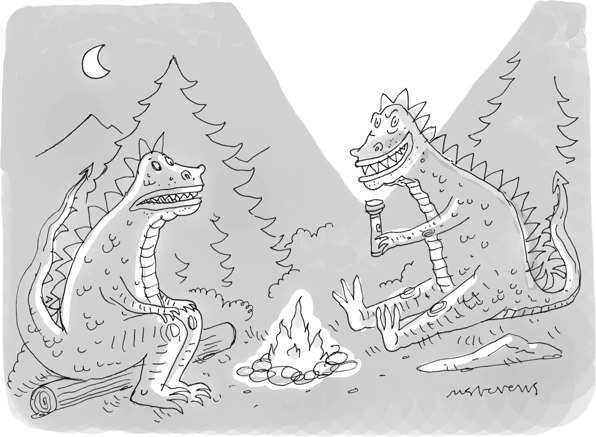

In [20]:
import requests
from PIL import Image

url = 'https://media.newyorker.com/cartoons/63dc6847be24a6a76d90eb99/master/w_1160,c_limit/230213_a26611_838.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')  
display(image.resize((596, 437)))


In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)


### 图像描述生成

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


two cartoon monsters sitting around a campfire


### 有提示图像描述生成

In [23]:
prompt = "this is a cartoon of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


two monsters sitting around a campfire


In [24]:
prompt = "they look like they are"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


having a good time


## VQA

In [25]:
prompt = "Question: What is a dinosaur holding? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


A torch


## 基于聊天的提示

In [26]:
context = [
   ("What is a dinosaur holding?", "a torch"),
   ("Where are they?", "In the woods.")
]
question = "What for?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)


Question: What is a dinosaur holding? Answer: a torch. Question: Where are they? Answer: In the woods.. Question: What for? Answer:


In [27]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


To light a fire.


## offical demo

In [17]:
!pip3 install salesforce-lavis

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 5.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 32.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

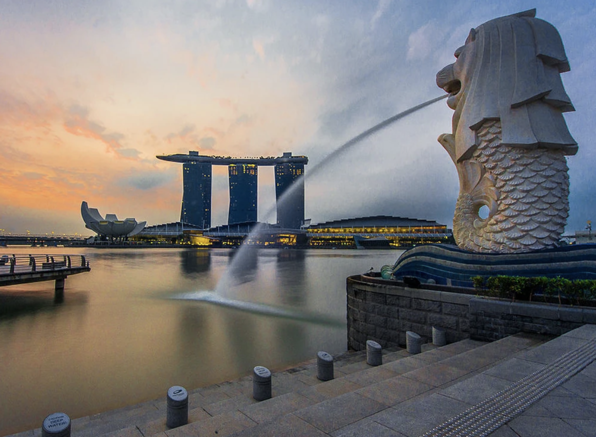

In [18]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   
display(raw_image.resize((596, 437)))

In [19]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [ ]:
# we associate a model with its preprocessors to make it easier for inference.
# model, vis_processors, _ = load_model_and_preprocess(
#    name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device
# )

# Other available models:
# 
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
)
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()

In [ ]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

In [ ]:
model.generate({"image": image})

In [ ]:
# due to the non-determinstic nature of necleus sampling, you may get different captions.
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

In [ ]:
model.generate({"image": image, "prompt": "Question: which city is this? Answer:"})

In [ ]:
model.generate({
    "image": image,
    "prompt": "Question: which city is this? Answer: singapore. Question: why?"})

In [ ]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

In [ ]:
model.generate(
    {
    "image": image,
    "prompt": prompt
    },
    use_nucleus_sampling=False,
)